# 앙상블 (Ensemble)
- 다양한 모델을 결합하여 예측 성능을 향상시키는 방법
- 투표(Voting), 배깅(Bagging), 부스팅(Boosting), 스태킹(Stacking) 네 가지로 구분

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
import warnings
warnings.filterwarnings('ignore')

### Voting
- hard voting: 여러 개의 예측치에 대해 다수결로 결정
- soft voting: 여러 개의 예측 확률을 평균내어 결정

위스콘신 유방암 데이터셋 (Wisconsin Breast Cancer Dataset)
유방암의 악성(Malignant)과 양성(Benign)을 분류하기 위해 자주 사용되는 데이터셋 (의학적인 이미지를 바탕으로 유방암 종양의 특징을 수치화한 데이터)

##### 데이터셋 개요

- 목적: 유방암 종양이 악성(Malignant)인지, 양성(Benign)인지 분류
- 샘플 수: 569개
- 특징(Features) 수: 30개
- 타겟(Target): 0(악성) 또는 1(양성)
##### 데이터 구성

1. Radius mean: 종양의 평균 반지름
2. Texture mean: 종양의 표면의 거칠기
3. Perimeter mean: 종양의 평균 둘레 길이
4. Area mean: 종양의 평균 면적
5. Smoothness mean: 종양의 매끄러움 정도
6. Compactness mean: 종양의 압축도
7. Concavity mean: 종양의 오목함
8. Concave points mean: 종양의 오목한 점 개수
9. Symmetry mean: 종양의 대칭성
10. Fractal dimension mean: 종양의 프랙탈 차원

In [148]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [149]:
df['target'].value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [150]:
# 데이터 준비 (분리)
from sklearn.model_selection import train_test_split

x = data.data
y = data.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### hard voting

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)    
    ],
    voting='hard'    # 기본값
)

# 앙상블 모델 학습
voting_clf.fit(x_train, y_train)

# 예측 및 평가
y_pred_train = voting_clf.predict(x_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 정수:', acc_score_train)

y_pred_test = voting_clf.predict(x_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print('테스트 평가 점수:', acc_score_test)

학습 정수: 0.9714285714285714
테스트 평가 점수: 0.9736842105263158


In [152]:
# hard voting 작동 원리 == 다수결
start, end = 40, 50

voting_clf_pred = voting_clf.predict(x_test[start:end])
print('앙상블 예측값:', voting_clf_pred)

for classfier in [knn_clf, lr_clf, dt_clf]:
    # 개별 학습 및 예측
    classfier.fit(x_train, y_train)
    pred = classfier.predict(x_test)
    acc_score = accuracy_score(y_test, pred)

    class_name = classfier.__class__.__name__       # 클래스의 이름 속성
    print(f'{class_name} 개별 정확도: {acc_score:.4f}')
    print(f'{class_name} 예측값: {pred[start:end]}')

앙상블 예측값: [0 1 0 1 0 0 1 1 1 0]
KNeighborsClassifier 개별 정확도: 0.9386
KNeighborsClassifier 예측값: [0 1 0 1 0 0 1 1 1 0]
LogisticRegression 개별 정확도: 0.9649
LogisticRegression 예측값: [0 1 0 1 0 0 1 1 1 0]
DecisionTreeClassifier 개별 정확도: 0.9123
DecisionTreeClassifier 예측값: [1 1 0 1 0 0 1 1 1 0]


### soft voting

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier(random_state=0)

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)    
    ],
    voting='soft'    # 기본값
)

# 앙상블 모델 학습
voting_clf.fit(x_train, y_train)

# 예측 및 평가
y_pred_train = voting_clf.predict(x_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 정수:', acc_score_train)

y_pred_test = voting_clf.predict(x_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print('테스트 평가 점수:', acc_score_test)

학습 정수: 0.989010989010989
테스트 평가 점수: 0.9649122807017544


In [154]:
# soft voting 작동 원리 == 각 예측가의 확률값 평균

start, end = 40, 50

voting_clf_pred_proba = voting_clf.predict_proba(x_test[start:end])
print('앙상블 예측값:', voting_clf_pred_proba)

for classfier in [knn_clf, lr_clf, dt_clf]:
    # 개별 학습 및 예측
    classfier.fit(x_train, y_train)                                                             
    
    pred = classfier.predict(x_test)
    acc_score = accuracy_score(y_test, pred)
    pred_proba = classfier.predict_proba(x_test[start:end])

    class_name = classfier.__class__.__name__       # 클래스의 이름 속성
    print(f'{class_name} 개별 정확도: {acc_score:.4f}')
    print(f'{class_name} 예측값: {pred[start:end]}')

앙상블 예측값: [[5.77219228e-01 4.22780772e-01]
 [6.81827764e-04 9.99318172e-01]
 [9.99526759e-01 4.73241064e-04]
 [2.77579326e-04 9.99722421e-01]
 [9.00069906e-01 9.99300938e-02]
 [1.00000000e+00 1.59599463e-13]
 [6.74633161e-05 9.99932537e-01]
 [1.53322319e-02 9.84667768e-01]
 [9.19791079e-04 9.99080209e-01]
 [9.99839494e-01 1.60506219e-04]]
KNeighborsClassifier 개별 정확도: 0.9386
KNeighborsClassifier 예측값: [0 1 0 1 0 0 1 1 1 0]
LogisticRegression 개별 정확도: 0.9649
LogisticRegression 예측값: [0 1 0 1 0 0 1 1 1 0]
DecisionTreeClassifier 개별 정확도: 0.9123
DecisionTreeClassifier 예측값: [1 1 0 1 0 0 1 1 1 0]


### Bagging
- Bootstrap Aggregation
- Bootstrap 방식의 샘플링: 각 estimator 마다 훈련 데이터를 뽑을 때, 중복 값이 허용하는 방식
- 분류 모델의 경우, 각 tree(estimator)의 예측값을 다수결(hard voting) 결정
- 회구 모델의 경우, 각 tree(estimator)의 예측값을 평균내어 결정
- 기본적으로 100개의 tree 사용

##### 하이퍼 파라미터

In [155]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)

# 학습
rf_clf.fit(x_train, y_train)

# 예측
y_pred_train = rf_clf.predict(x_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

y_pred_test = rf_clf.predict(x_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print('테스트 평가 점수:', acc_score_test)


학습 점수: 0.9978021978021978
테스트 평가 점수: 0.9649122807017544


In [156]:
# 100개의 DecisionTree 확인
# print(rf_clf.estimators_)

# 100개의 DecisionTree가 사용한 샘플데이터 확인
# print(rf_clf.estimators_samples_)

# Bootstrap 방식의 샘플링 확인
for i, sample_indexs in enumerate(rf_clf.estimators_samples_):
    print(f'{i}번째 DecisionTree의 샘플 인덱스: {sorted(sample_indexs)}')

0번째 DecisionTree의 샘플 인덱스: [np.int32(0), np.int32(0), np.int32(1), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(12), np.int32(12), np.int32(13), np.int32(16), np.int32(16), np.int32(16), np.int32(20), np.int32(22), np.int32(22), np.int32(24), np.int32(25), np.int32(25), np.int32(26), np.int32(31), np.int32(32), np.int32(32), np.int32(32), np.int32(35), np.int32(36), np.int32(36), np.int32(36), np.int32(38), np.int32(38), np.int32(40), np.int32(41), np.int32(41), np.int32(44), np.int32(45), np.int32(49), np.int32(49), np.int32(49), np.int32(53), np.int32(53), np.int32(55), np.int32(56), np.int32(56), np.int32(56), np.int32(57), np.int32(57), np.int32(57), np.int32(57), np.int32(59), np.int32(59), np.int32(60), np.int32(60), np.int32(62), np.int32(63), np.int32(63), np.int32(64), np.int32(65), np.int32(65), np.int32(66), np.int32(66), np.int32(66), np.int32(71), np.int32(72), np.int32(73), np.int32(75), np.int32(76), np.int32(77), np.

In [157]:
# 특성 중요도 확인
feat_imptc_ser = pd.Series(rf_clf.feature_importances_, index=data.feature_names).sort_values(ascending=False)
feat_imptc_ser

worst perimeter            0.172430
worst concave points       0.140100
worst radius               0.099627
mean concave points        0.086525
mean concavity             0.080100
mean perimeter             0.061155
worst area                 0.045312
mean area                  0.039868
area error                 0.039454
mean radius                0.037348
radius error               0.024821
worst concavity            0.024339
worst texture              0.019695
worst compactness          0.014538
mean texture               0.013903
perimeter error            0.012007
worst smoothness           0.011433
worst fractal dimension    0.009596
worst symmetry             0.009481
mean compactness           0.008451
symmetry error             0.006640
mean smoothness            0.006420
fractal dimension error    0.005809
texture error              0.005569
concavity error            0.005548
concave points error       0.005409
compactness error          0.004150
mean fractal dimension     0

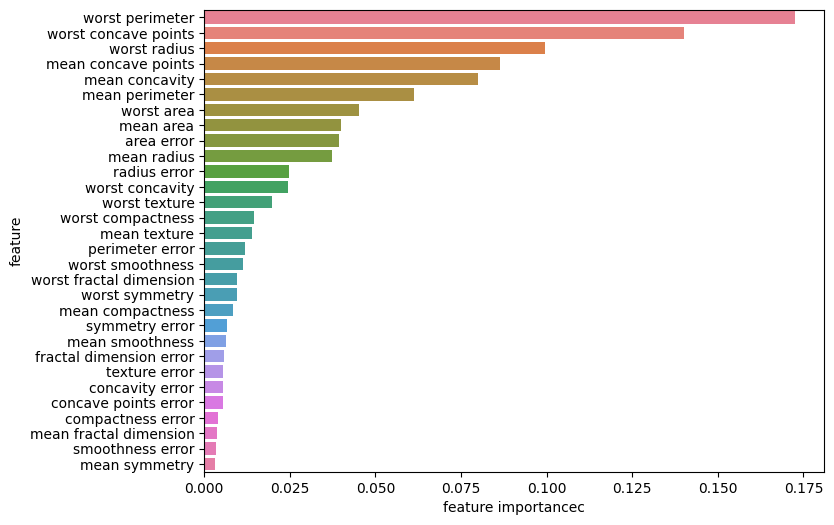

In [158]:
# 특성 중요도 시각화
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_imptc_ser,
    y = feat_imptc_ser.index,
    hue=feat_imptc_ser.index    
)
plt.xlabel('feature importancec')
plt.ylabel('feature')
plt.show()

##### 와인데이터 셋 이진분류

학습 점수: 0.996921300750433
테스트 평가 점수: 0.8907692307692308


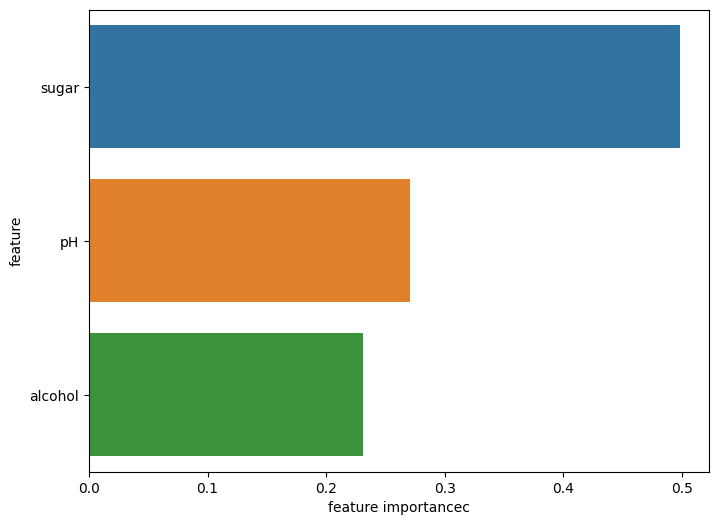

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
wine_data = pd.read_csv('./data/wine_simple.csv')
x = wine_data.drop('class', axis=1)
y = wine_data['class']

# 2. 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 3. RandomForestClassifier 모델 생성 및 학습
rfc_clf = RandomForestClassifier()
rfc_clf.fit(x_train, y_train)

# 4. 예측
y_pred_train = rfc_clf.predict(x_train)

y_pred_test = rfc_clf.predict(x_test)

# 5. 정확도 출력
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

acc_score_test = accuracy_score(y_test, y_pred_test)
print('테스트 평가 점수:', acc_score_test)

# 6. 특성 중요도 시각화
feat_imptc_ser = pd.Series(rfc_clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_imptc_ser,
    y = feat_imptc_ser.index,
    hue=feat_imptc_ser.index    
)
plt.xlabel('feature importancec')
plt.ylabel('feature')
plt.show()

### 인간행동인식 다중분류

정확도: 0.9267051238547676


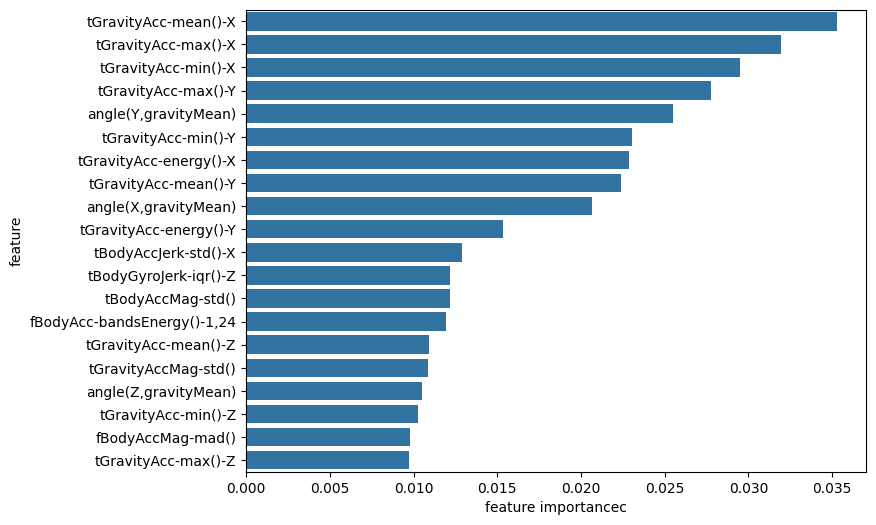

In [160]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. 데이터 로드
har_train_df = pd.read_csv('./data/har_train.csv')
har_test_df = pd.read_csv('./data/har_test.csv')

# har_train_df.info()
# print(har_train_df.columns)
# print(har_test_df.columns)
# 2. 데이터 분리

x_train = har_train_df.drop('Activity', axis=1)
x_test = har_test_df.drop('Activity', axis=1)
y_train = har_train_df['Activity']
y_test = har_test_df['Activity']


# 3. 레이블 인코딩

label_encoding = LabelEncoder()
y_train_encoded = label_encoding.fit_transform(y_train)
y_test_encoded = label_encoding.fit_transform(y_test)

# 4. 데이터 정규화
# X_train.describe()
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 5. RandomForestClassifier 모델 학습
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(x_train_scaled, y_train_encoded)

# 6. 모델 예측
y_pred = rf_clf.predict(x_test_scaled)

# 7. 평가 (정확도)
acc_score = accuracy_score(y_test_encoded, y_pred)
print(f"정확도: {acc_score}")

# 8. 중요도 상위 20개의 특성 시각화
feat_iptcs = rf_clf.feature_importances_
feat_names = x_train.columns

iptcs_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': feat_iptcs        
}).sort_values(by='Importance', ascending=False).head(20)

feat_imptc_ser = pd.Series(rfc_clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(
    y=iptcs_df['Feature'],
    x=iptcs_df['Importance'], 
)
plt.xlabel('feature importancec')
plt.ylabel('feature')
plt.show()

### Boosting
- 깊이가 얕은 결정트리를 사용해 이진 트리의 오차를 보정하는 방식
- 순차적으로 경사하강법을 사용해 이진 트리의 오차를 줄여나감
    - 분류모델에서는 손실함수 Logloss를 사용해 오차를 줄임
    - 회귀모델에서는 손실함수 MSA를 사용해 오차를 줄임
- Boosting 계열은 일반적으로 결정트리 개수를 늘려도 과적합에 강함
- 대표적인 알고리즘(모델): GradientBoosting, HistGradientBoosting, XGBoost, LightGBM, CatBoost

##### GradientBoosting 구현

In [161]:
from sklearn.tree import DecisionTreeRegressor

In [162]:

class SimpleGradientBoostingClassifier:

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.initial_log_odds = 0   # 초기 예측값
        self.trees = []     # estimator 모음 배열

    def log_odds(self, p):
        # 확률값 -> 로직 변환 : 0~1 사이의 값을 펼쳐 -무한대~ +무한대 사이의 값으로 보정
        return np.log(p / (1 - p))
    
    def sigmoid(self, z):
        # z값 -> 0~1 사이의 확률 값 반환
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # 초기 예측값 설정
        y_mean = np.mean(y)
        self.initial_log_odds = self.log_odds(y_mean)
        y_pred_log_odds = np.full_like(y, self.initial_log_odds, dtype=np.float64)

        # 모델 생성 및 학습
        for _ in range(self.n_estimators):
            # 현재 상태에서 예측된 확률값 계산
            y_pred_proba = self.sigmoid(y_pred_log_odds)

            # 잔차 계산
            residual = y - y_pred_proba

            # 결정트리 생성 및 학습
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)   # 잔차를 라벨로 학습
            self.trees.append(tree)

            # 예측값 업데이트 (예측값 정진적 개선)
            y_pred_log_odds += self.learning_rate * tree.predict(X)
            
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def predict_proba(self, X):
        y_pred_log_odds = np.full((X.shape[0],), self.initial_log_odds)

        # 트리의 예측값을 누적하여 최종 로직값 계산
        for tree in self.trees:
            y_pred_log_odds += self.learning_rate * tree.predict(X)

        return self.sigmoid(y_pred_log_odds)


In [163]:
# SimpleGradientBoostingClassifier로 유방암 데이터 예측

data = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)

simple_gb_clf = SimpleGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

simple_gb_clf.fit(X_train, y_train)

y_pred_train = simple_gb_clf.predict(X_train)
y_pred_test = simple_gb_clf.predict(X_test)

print(f'학습 정확도: {accuracy_score(y_train, y_pred_train)}')
print(f'평가 정확도: {accuracy_score(y_test, y_pred_test)}')



학습 정확도: 0.9953051643192489
평가 정확도: 0.9230769230769231


##### GradientBoosting

In [164]:
# GradientBoostingClassifier로 유방암 데이터 예측
from sklearn.ensemble import GradientBoostingClassifier

data = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)

gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

gb_clf.fit(X_train, y_train)

y_pred_train = gb_clf.predict(X_train)
y_pred_test = gb_clf.predict(X_test)

print(f'학습 정확도: {accuracy_score(y_train, y_pred_train)}')
print(f'평가 정확도: {accuracy_score(y_test, y_pred_test)}')



학습 정확도: 1.0
평가 정확도: 0.9020979020979021


##### HistGradientBoosting
- 고성능 GradientBoosting 모델로 대규모 데이터셋 처리에 적합
- Histogram 기반으로 256개의 구간으로 나누어 처리 병합하는 방식
- 결측치가 있어도 전처리가 필요 없음
- LightGBM의 영향을 받아 만들어진 scikit-learn의 모델

In [165]:
from sklearn.ensemble import HistGradientBoostingClassifier

data = load_breast_cancer()
X_train, X_test, y_train, t_test = train_test_split(data.data, data.target, random_state=42)

hist_gb_clf = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    max_bins=255,      # 255개의 구간으로 나누어 처리 (1개는 결측치 전용)
    early_stopping=True,    # 반복 중 일정 횟수 이상 성능 향상이 없으면 학습 종료, False일 때 n_iter_no_change 기능 안함 
    n_iter_no_change=5      # '일정 횟수' 지정 (기본값: 10)
)
hist_gb_clf.fit(X_train, y_train)

y_pred_train = hist_gb_clf.predict(X_train)
y_pred_test = hist_gb_clf.predict(X_test)
print(f'학습 정확도 : {accuracy_score(y_train, y_pred_train)}')
print(f'평가 정확도 : {accuracy_score(y_test, y_pred_test)}')

학습 정확도 : 0.9835680751173709
평가 정확도 : 0.46153846153846156


In [166]:
# permutation_important == 특성 중요도
from sklearn.inspection import permutation_importance

result = permutation_importance(
    hist_gb_clf,
    X_train,
    y_train,
    n_repeats=5,
    random_state=0
)

# importances_mean : 평균 중요도
# importances_std : 중요도 표준편차
# importances : 특성 중요도
result.importances

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00938967,  0.00704225,  0.01173709,  0.00938967,  0.00704225],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00469484,  0.01643192,  0.00704225,  0.01643192,  0.00704225],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.00234742,  0.00234742,  0.00234742,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.0

### 회귀모델

In [180]:
from sklearn.datasets import load_diabetes

diabeted = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabeted.data, diabeted.target, random_state=0)



In [172]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

hist_gb_reg = HistGradientBoostingRegressor(
    max_iter=100,
    max_depth=3,
    learning_rate=0.05,
    random_state=0,
    l2_regularization=0.5,
    min_samples_leaf=5
)
hist_gb_reg.fit(X_train, y_train)

y_pred_train = hist_gb_reg.predict(X_train)
y_pred_test = hist_gb_reg.predict(X_test)

print(f'학습 msa: {mean_squared_error(y_train, y_pred_train)} 학습 R2: {r2_score(y_train, y_pred_train)}')
print(f'평가 msa: {mean_squared_error(y_test, y_pred_test)} 학습 R2: {r2_score(y_test, y_pred_test)}')

학습 msa: 1349.7927482181808 학습 R2: 0.7841531432486148
평가 msa: 3692.3791002557186 학습 R2: 0.256230565040123


In [177]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter' : [100, 200, 300],
    'max_depth' : [1, 3, 5],
    'learning_rate' : [0.01, 0.05, 0.1],
    'min_samples_leaf' : [10, 20, 30],
    'l2_regularization' : [0.0, 0,1, 1.0],
    'max_bins' : [255, 127]
    }

hist_gb_reg = HistGradientBoostingRegressor(random_state=0)
grid_search = GridSearchCV(hist_gb_reg, param_grid, cv=3, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

grid_search.best_params_    # 최고의 성능을 내는 하이퍼 파라미터

{'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'max_bins': 127,
 'max_depth': 1,
 'max_iter': 200,
 'min_samples_leaf': 20}

In [183]:
best_hist_gb_reg = grid_search.best_estimator_

y_pred_train = best_hist_gb_reg.predict(X_train)
y_pred_test = best_hist_gb_reg.predict(X_test)

print(f'학습 msa: {mean_squared_error(y_train, y_pred_train)} 학습 R2: {r2_score(y_train, y_pred_train)}')
print(f'평가 msa: {mean_squared_error(y_test, y_pred_test)} 학습 R2: {r2_score(y_test, y_pred_test)}')

학습 msa: 2168.484353327469 학습 R2: 0.653235259858844
평가 msa: 3455.1451971700467 학습 R2: 0.3040174583304508
